In [1]:
import os
import glob as glob
import matplotlib.pyplot as plt
import cv2
import requests
import random
import numpy as np

np.random.seed(42)

In [2]:
'''The current annotations in the text files are in normalized `[x_center, y_center, width, height]` format.
    Let's write a function that will convert it back to `[x_min, y_min, x_max, y_max]` format to check these annotations'''

def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2] / 2, bboxes[1] - bboxes[3] / 2
    xmax, ymax = bboxes[0]+bboxes[2] / 2, bboxes[1] + bboxes[3] / 2
    return xmin, ymin, xmax, ymax

In [6]:
# Change this list to match your data.yaml file
class_names = ['ambulance', 'vehicle']

# This line now correctly creates 2 colors, one for each class
colors = np.random.uniform(0, 255, size=(len(class_names), 3))

def yolo2bbox(box):
    # This is a placeholder function. You likely have this defined elsewhere.
    # It converts YOLO format [x_center, y_center, width, height]
    # to [x_min, y_min, x_max, y_max]
    x, y, w, h = box
    x1, y1 = x - w/2, y - h/2
    x2, y2 = x + w/2, y + h/2
    return x1, y1, x2, y2

def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        
        # denormalize the coordinates
        xmin = int(x1 * w)
        ymin = int(y1 * h)
        xmax = int(x2 * w)
        ymax = int(y2 * h)
        
        # This line will now work correctly with your model's output (0 or 1)
        class_name = class_names[int(labels[box_num])]
        
        cv2.rectangle(
            image, 
            (xmin, ymin), (xmax, ymax),
            color=colors[class_names.index(class_name)],
            thickness=2
        ) 

        font_scale = min(1,max(3,int(w/500)))
        font_thickness = min(2, max(10,int(w/50)))
        
        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        
        # Text width and height
        tw, th = cv2.getTextSize(class_name, 0, fontScale=font_scale, thickness=font_thickness)[0]
        p2 = p1[0] + tw, p1[1] + -th - 10
        cv2.rectangle(
            image, 
            p1, p2,
            color=colors[class_names.index(class_name)],
            thickness=-1,
        )
        cv2.putText(
            image, 
            class_name,
            (xmin+1, ymin-10),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (255, 255, 255),
            font_thickness
        )
    return image

In [7]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_training_images = glob.glob(image_paths)
    all_training_labels = glob.glob(label_paths)
    all_training_images.sort()
    all_training_labels.sort()
    
    num_images = len(all_training_images)
    
    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image = cv2.imread(all_training_images[j])
        with open(all_training_labels[j], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.show()

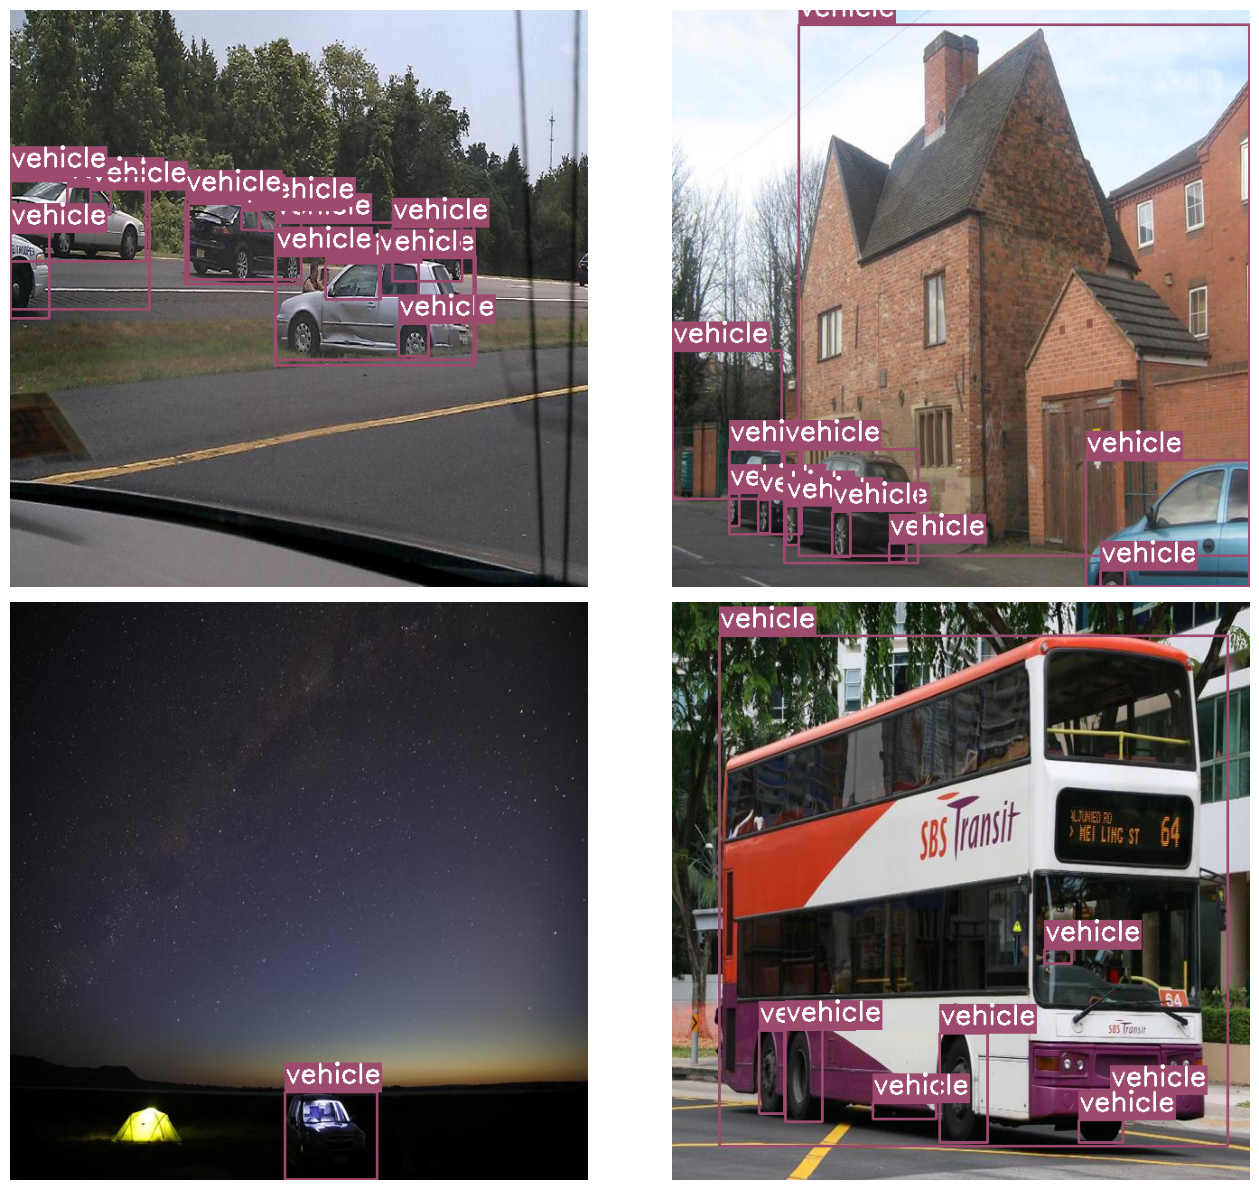

In [8]:
plot(image_paths=r'C:\Users\gandhi72\Documents\yolo_dataset_50k\train\images\*',
     label_paths=r'C:\Users\gandhi72\Documents\yolo_dataset_50k\train\labels\*',
     num_samples=4)

In [9]:
import torch

def verify_gpu():
    """
    Checks if a CUDA-enabled GPU is available and prints its details.
    Ultralytics' YOLO automatically uses the GPU if it's available.
    """
    print("--- GPU Verification ---")
    try:
        if torch.cuda.is_available():
            gpu_count = torch.cuda.device_count()
            print(f"✅ Success! Found {gpu_count} CUDA-enabled GPU(s).")
            for i in range(gpu_count):
                gpu_name = torch.cuda.get_device_name(i)
                print(f"  - GPU {i}: {gpu_name}")
            print(f"Ultralytics will automatically use: {torch.cuda.get_device_name(0)}")
        else:
            print("⚠️ Warning: No CUDA-enabled GPU found.")
            print("Training will proceed on the CPU, which will be significantly slower.")
    except Exception as e:
        print(f"An error occurred while checking for the GPU: {e}")
    finally:
        print("----------------------\n")


In [10]:
verify_gpu()

--- GPU Verification ---
✅ Success! Found 1 CUDA-enabled GPU(s).
  - GPU 0: NVIDIA GeForce GTX 1050 Ti
Ultralytics will automatically use: NVIDIA GeForce GTX 1050 Ti
----------------------



In [11]:
from ultralytics import YOLO

# Load a COCO-pretrained YOLO11n model
model = YOLO("yolo11n.pt")

100%|██████████| 5.35M/5.35M [00:01<00:00, 4.95MB/s]


In [13]:
results = model.train(data=r"C:\Users\gandhi72\Documents\yolo_dataset_50k\data.yaml", epochs=100, imgsz=640)

New https://pypi.org/project/ultralytics/8.3.191 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.107  Python-3.10.11 torch-2.4.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4096MiB)
engine\trainer: task=detect, mode=train, model=yolo11n.pt, data=C:\Users\gandhi72\Documents\yolo_dataset_50k\data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=No

train: Scanning C:\Users\gandhi72\Documents\yolo_dataset_50k\train\labels... 35000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 35000/35000 [01:10<00:00, 499.70it/s]

train: WARNING  C:\Users\gandhi72\Documents\yolo_dataset_50k\train\images\00296b0c54457743.jpg: 1 duplicate labels removed
train: WARNING  C:\Users\gandhi72\Documents\yolo_dataset_50k\train\images\002db8012f87a91a.jpg: 1 duplicate labels removed
train: WARNING  C:\Users\gandhi72\Documents\yolo_dataset_50k\train\images\005e9a78ac73a118.jpg: 1 duplicate labels removed
train: WARNING  C:\Users\gandhi72\Documents\yolo_dataset_50k\train\images\01492ca7b65d02ba.jpg: 1 duplicate labels removed
train: WARNING  C:\Users\gandhi72\Documents\yolo_dataset_50k\train\images\015d88643812decf.jpg: 1 duplicate labels removed
train: WARNING  C:\Users\gandhi72\Documents\yolo_dataset_50k\train\images\024a282cdc754de8.jpg: 1 duplicate labels removed
train: WARNING  C:\Users\gandhi72\Documents\yolo_dataset_50k\train\images\02532343ebb3c888.jpg: 1 duplicate labels removed
train: WARNING  C:\Users\gandhi72\Documents\yolo_dataset_50k\train\images\039ded35f7233e4f.jpg: 1 duplicate labels removed
train: WARNING  

train: New cache created: C:\Users\gandhi72\Documents\yolo_dataset_50k\train\labels.cache


INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning C:\Users\gandhi72\Documents\yolo_dataset_50k\val\labels... 5000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5000/5000 [00:11<00:00, 420.47it/s]

val: WARNING  C:\Users\gandhi72\Documents\yolo_dataset_50k\val\images\002d1dd67c722d98.jpg: 1 duplicate labels removed
val: WARNING  C:\Users\gandhi72\Documents\yolo_dataset_50k\val\images\03a54515e1de5422.jpg: 1 duplicate labels removed
val: WARNING  C:\Users\gandhi72\Documents\yolo_dataset_50k\val\images\068338a53dfabda8.jpg: 1 duplicate labels removed
val: WARNING  C:\Users\gandhi72\Documents\yolo_dataset_50k\val\images\06bd98f272a9a61e.jpg: 1 duplicate labels removed
val: WARNING  C:\Users\gandhi72\Documents\yolo_dataset_50k\val\images\0c08c1a56daae22a.jpg: 1 duplicate labels removed
val: WARNING  C:\Users\gandhi72\Documents\yolo_dataset_50k\val\images\0ca06a9280f4d1ae.jpg: 1 duplicate labels removed
val: WARNING  C:\Users\gandhi72\Documents\yolo_dataset_50k\val\images\0df421b851ea7156.jpg: 1 duplicate labels removed
val: WARNING  C:\Users\gandhi72\Documents\yolo_dataset_50k\val\images\11b155ab5b3331cf.jpg: 1 duplicate labels removed
val: WARNING  C:\Users\gandhi72\Documents\yolo_d

val: New cache created: C:\Users\gandhi72\Documents\yolo_dataset_50k\val\labels.cache
Plotting labels to runs\detect\train2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.65G      1.468      2.864      1.483        255        640:  13%|█▎        | 288/2188 [03:30<23:08,  1.37it/s]


KeyboardInterrupt: 